# Element 121: Type of Intersection/Junction

In [1]:
# import relevant types from our Python library
from dot.types.intersections import JunctionType, OSMJunction
from dot.types.osm import OSMNode

from dotenv import load_dotenv
load_dotenv()

# Counter efficiently collects statistics of distinct elements
from collections import Counter, defaultdict

The ``JunctionType`` enum matches the MIRE v2.0 schema

In [2]:
print(JunctionType.__doc__)
for x in JunctionType:
    print(x)


    Element 111: Type of Intersection/Junction

    Definition: Type of junction being described in the data record. Recommended Attributes:
    1. Roadway/roadway (not interchange related)
    2. Roadway/roadway (interchange ramp terminal)
    3. Roadway/pedestrian crossing (e.g., midblock crossing, pedestrian path or trail)
    4. Roadway/bicycle path or trail
    5. Roadway/railroad grade crossing
    6. Other
    
JunctionType.ROADWAY
JunctionType.INTERCHANGE_RAMP
JunctionType.PEDESTRIAN
JunctionType.BICYCLE_OR_TRAIL
JunctionType.RAILROAD
JunctionType.OTHER


## Inferring Junction Type with OpenStreetMap Data

### Get OSM data for Washington, DC

In [3]:
# Use osmnx library to interface with OpenStreetMap data
import osmnx

In [4]:

# Configure osmnx to request OpenStreetMap data tags we will need
way_tags = [
    'bridge',
    'tunnel',
    'highway',
    'footway',
    'lanes',
    'maxspeed',
    'name',
    'tiger:name_base',
    'official_name',
    'alt_name',
    'oneway',
    'noexit',
    'abutters',
    'embedded_rails',
    'incline',
    'junction',
    'lit',
    'overtaking',
    'parking:condition',
    'parking:lane',
    'smoothness',
    'surface',
    'tactile_paving',
    'tracktype',
    'traffic_calming',
    'turn',
    'turn:lanes',
    'abutters',  # commercial / industrial / mixed / residential / retail etc. https://wiki.openstreetmap.org/wiki/Key:abutters
    'bicycle_road',
    'embedded_rails',
    'place',
    'railway'
]
node_tags = [
    'ele',  # elevation
    'highway',  # turning circle, traffic signals, etc
    'ref',  # reference id?
    'barrier',
    'amenity',  # school, restaurant, parking, etc
    'emergency',  # firestation, hospital, etc
    'incline',
    'place',
    'name',
    'official_name',
    'alt_name',
]

osmnx.utils.config(
    use_cache=True,
    useful_tags_way=way_tags,
    useful_tags_node=node_tags,    
)

In [5]:
# Get OpenStreetMap data for Washington, DC
# Simplify resulting graph data to aggregate intersection information
G = osmnx.graph_from_place('Washington, DC', network_type='all', simplify=True)

### Access metadata from networkx graph objects

In [21]:
intersection_types = Counter()
all_roadtypes = Counter()
all_roadtype_sets = Counter()
intersections = []

for n in G.nodes:

    # Intersections are represented as nodes, roadways as edges
    # print(len(G.edges(n)))
    if len(G.edges(n)) < 2:  # not an intersection
        continue
        
    osm_node = OSMNode(
        nodeid=str(G.nodes[n]['osmid']),
        latitude=G.nodes[n]['y'],
        longitude=G.nodes[n]['x']
    )    

    roadtypes = set()
    roadway_names = set()    
    for e in G.edges(n):        
        # Look at every edge connected to this node        
        is_highway = False
        #for node_data in G[n].values():
        #    if 'highway' in node_data[0]:  # if node pertains to a highway, continue
        #        is_highway = True
        #        break
        
        
        edge_data = G[e[0]][e[1]]
        
        #if any(['tiger' in k for data in edge_data.values() for k in data.keys()]):
        #    print(edge_data.values())

        #if any(['highway' in data for data in edge_data.values()]):
        #    print(edge_data.values())

        highway_tags = [data['highway'] for data in edge_data.values() if 'highway' in data] + [f"railway:{data['railway']}" for data in edge_data.values() if 'railway' in data]
        
        for data in edge_data.values():
            if not 'name' in data:
                continue
            if isinstance(data['name'], str):
                roadway_names.update([data['name']])
            else:
                roadway_names.update(data['name'])

        # roadway_names.update([data['name'] for data in edge_data.values() if 'name' in data])

        flattened_tags = []
        for tag in highway_tags:
            if isinstance(tag, str):
                flattened_tags.append(tag)
            else:
                flattened_tags.extend(tag)
    
        all_roadtypes.update(flattened_tags)

        roadtypes.update(flattened_tags)

    # all_roadtype_sets.update([(tuple(roadtypes))])
    # print(roadtypes)

    junction_type = 0

    if 'path' in roadtypes and roadtypes & {'primary', 'secondary', 'tertiary', 'motorway', 'residential', 'service'}:
        junction_type |= JunctionType.PEDESTRIAN
    if 'cycleway' in roadtypes or 'trail' in roadtypes:
        junction_type |= JunctionType.BICYCLE_OR_TRAIL
    if any(['railway' in x for x in roadtypes]):
        junction_type |= JunctionType.RAILROAD
    if roadtypes & {'primary', 'secondary', 'tertiary', 'residential', 'service'}:
        junction_type |= JunctionType.ROADWAY
    if roadtypes & {'motorway', 'junction'}:
        junction_type |= JunctionType.INTERCHANGE_RAMP
    
    if not junction_type:
        junction_type = JunctionType.OTHER

    intersections.append(
        OSMJunction(
            osm_node=osm_node,
            junction_type=junction_type,
            names=roadway_names
        )
    )


2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class 'tuple'> 2
<class '

KeyboardInterrupt: 

In [15]:
len(intersections)

35645

In [16]:
from dot.tiles import get_cropped_centered_img
img = get_cropped_centered_img(lat=intersections[30774].osm_node.latitude, lon=intersections[30774].osm_node.longitude, mapbox_token=os.getenv('MAPBOX_TOKEN'), zoom=18)

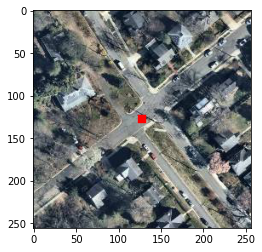

In [17]:
import matplotlib.pylab as plt
plt.imshow(img)

In [18]:
for j, i in enumerate(intersections):
    if i.junction_type & JunctionType.RAILROAD:
        print(j, i)
print(intersections[4])

7193 junction_type=<JunctionType.RAILROAD|BICYCLE_OR_TRAIL: 24> num_legs=None geometry_type=None geometry=None angle=None osm_node=OSMNode(nodeid='49886803', latitude=38.9192065, longitude=-77.1016047) names=['Capital Crescent Trail']
7194 junction_type=<JunctionType.RAILROAD|BICYCLE_OR_TRAIL: 24> num_legs=None geometry_type=None geometry=None angle=None osm_node=OSMNode(nodeid='49886811', latitude=38.9241584, longitude=-77.1072069) names=['Capital Crescent Trail']
8067 junction_type=<JunctionType.RAILROAD|BICYCLE_OR_TRAIL: 24> num_legs=None geometry_type=None geometry=None angle=None osm_node=OSMNode(nodeid='479662933', latitude=38.9193488, longitude=-77.1016965) names=['Capital Crescent Trail']
8068 junction_type=<JunctionType.RAILROAD|BICYCLE_OR_TRAIL: 24> num_legs=None geometry_type=None geometry=None angle=None osm_node=OSMNode(nodeid='479662937', latitude=38.9180595, longitude=-77.1008513) names=['Capital Crescent Trail']
8345 junction_type=<JunctionType.RAILROAD|BICYCLE_OR_TRAIL

In [11]:
edges = list(G.edges(n))

print(G[e[0]][e[1]])
# print(edges)

{0: {'osmid': 879374046, 'oneway': False, 'length': 22.606, 'geometry': <shapely.geometry.linestring.LineString object at 0x15fc8e430>}}


In [39]:
print(intersections[0])

junction_type=<JunctionType.PEDESTRIAN|ROADWAY: 5> num_legs=None geometry_type=None geometry=None angle=None osm_node=OSMNode(nodeid='29918140', latitude=38.9651003, longitude=-77.0471434)
